In [48]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import linkage, dendrogram

# K-Means Clustering

In [49]:
df = pd.read_csv("RFM_preprocessed.csv")
df = df.set_index("CustomerID")
df.head()

,Frequency,Monetary,Recency
CustomerID,,,
12347,5.204007,8.368693,0.693147
12348,3.433987,7.494007,4.317488
12349,4.290459,7.471676,2.944439
12350,2.833213,5.812338,5.736572
12352,4.553877,7.343045,3.583519


In [50]:
# let's find inertia scores and silhouette scores for different values of clusters
inertia_values = []
silhouette_scores = []

# loops through cluster numbers of 2 to 16 
for k in range(2,16):
    kmeans = KMeans(n_clusters = k, n_init = 10, random_state = 420)
    kmeans.fit(df)
    # appends the inertia scores
    inertia_values.append(kmeans.inertia_)
    # appends the silhouette scores
    silhouette_scores.append(silhouette_score(df, kmeans.labels_))

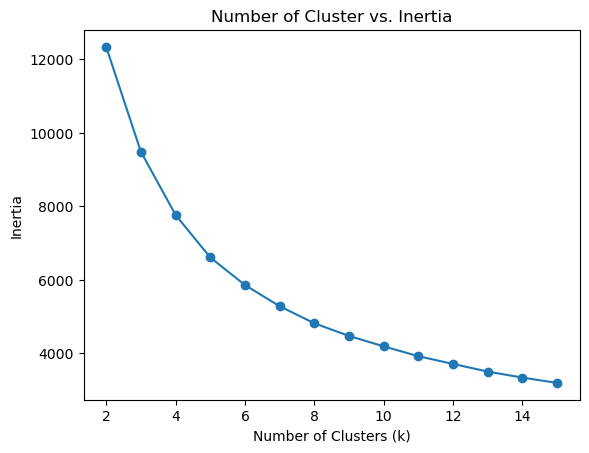

In [51]:
# transform array into pandas series 
inertia_series = pd.Series(inertia_values, index = range(2, 16))

# plots inertia values for each cluster number
inertia_series.plot(marker = 'o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel("Inertia")
plt.title("Number of Cluster vs. Inertia")
plt.show()

### It is tough to find the elbow of the plot. Let's check the Silhouette score.

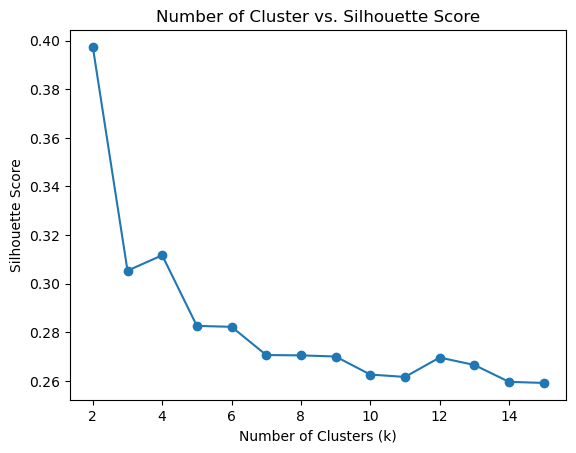

In [52]:
# transform array into pandas series 
silhouette_series = pd.Series(silhouette_scores, index = range(2, 16))

# plots salhouette scores for each cluster number
silhouette_series.plot(marker = 'o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel("Silhouette Score")
plt.title("Number of Cluster vs. Silhouette Score")
plt.show()

#### k = 4 looks a reasonable choice as it has lower inertia than other lower cluster numbers and around 0.32 of silhouette score, which is not much different from the highest silhouette score of 0.4, which is for the k = 2 clusters.

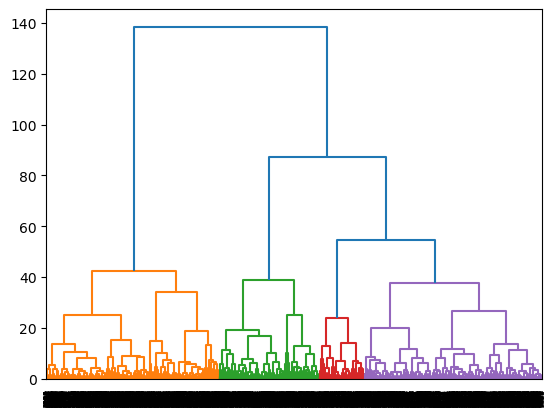

In [53]:
# visualisation of the hierarchical clustering 
linkage_matrix = linkage(df, method = "ward")
dendo = dendrogram(linkage_matrix, color_threshold = 50)

In [54]:
# fitting agglomerative cluster using the cluster number that we selected visually in the last plot
agg = AgglomerativeClustering(n_clusters = 4, metric = "euclidean", linkage = "ward")
agg.fit(df)

AgglomerativeClustering(n_clusters=4)

In [55]:
# silhouette score of the agglomerative cluster with 4 clusters
silhouette_score(df, agg.labels_)

np.float64(0.27512196642664766)

### while visualisation clustering support our k=4 clustering, but have lower silhouette score than k-means clustering. Therefore, we stick to out k-means clustering with 4 clusters.

In [56]:
#fitting clustering kmeans model with 4 clusters
kmeans = KMeans(n_clusters = 4, n_init = 10, random_state = 420)
kmeans.fit(df)

KMeans(n_clusters=4, n_init=10, random_state=420)

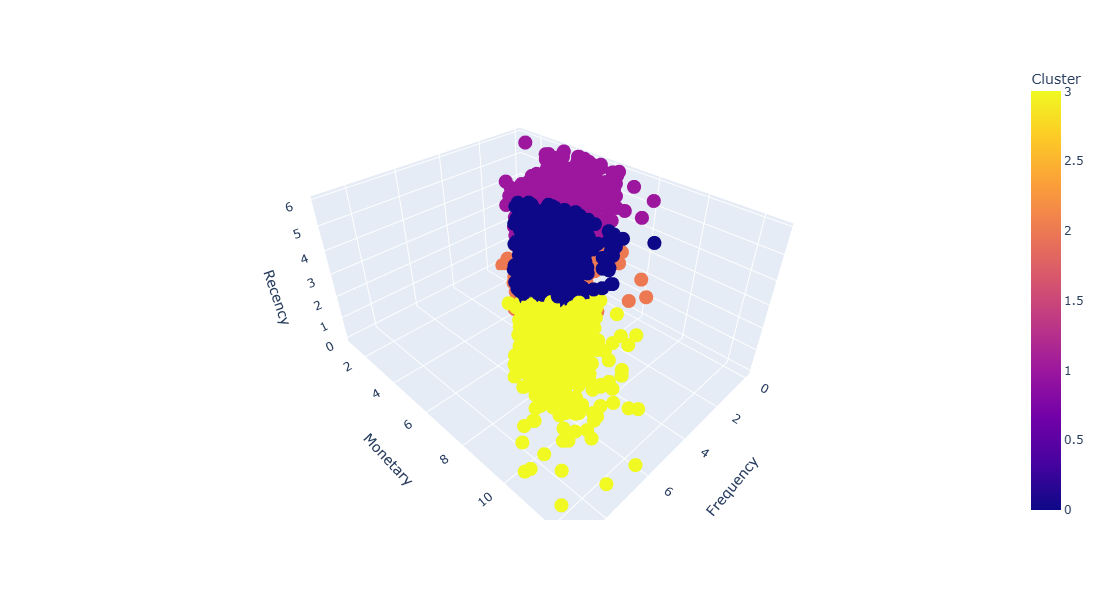

In [57]:
# combine the data and cluster labels
cluster_labels = pd.Series(kmeans.labels_, name = "Cluster", index = df.index)
df_clean = pd.concat([df, cluster_labels], axis = 1)

# create an interactive 3d plot with clusters
fig = px.scatter_3d(df_clean, x='Frequency', y='Monetary', z='Recency', 
                    color='Cluster', width=800, height=600)
fig.show()

In [58]:
df_clean.head()

,Frequency,Monetary,Recency,Cluster
CustomerID,,,,
12347,5.204007,8.368693,0.693147,3
12348,3.433987,7.494007,4.317488,0
12349,4.290459,7.471676,2.944439,0
12350,2.833213,5.812338,5.736572,1
12352,4.553877,7.343045,3.583519,0


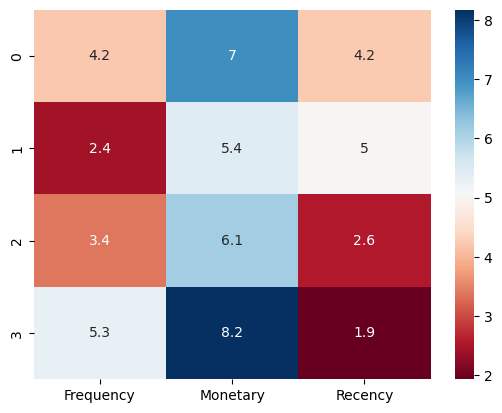

In [59]:
# extract centroids from each cluster 
cluster_centers = pd.DataFrame(kmeans.cluster_centers_, columns = df.columns)

# plot a heatmap for each centroids
sns.heatmap(cluster_centers, cmap = "RdBu", annot = True)
plt.show()

In [60]:
# cluster 0: at-risk
# cluster 1: one-timers 
# cluster 2: regulars
# cluster 3: VIP loyal customers


# target marketing can be done using these clusters.

In [61]:
# dictionary with each cluster mapping
cluster_name_mapping = {
    0: "At-risk",
    1: "One-timers",
    2: "Regulars",
    3: "VIP loyal customers"
}

df_clust = df_clean.copy()
# convert Cluster column to dtype of object
df_clust["Cluster"] = df_clust["Cluster"].astype("object")
# assigning each clusters to their mapped cluster name
df_clust["Cluster"] = df_clust["Cluster"].map(cluster_name_mapping)

df_clust.head()

,Frequency,Monetary,Recency,Cluster
CustomerID,,,,
12347,5.204007,8.368693,0.693147,VIP loyal customers
12348,3.433987,7.494007,4.317488,At-risk
12349,4.290459,7.471676,2.944439,At-risk
12350,2.833213,5.812338,5.736572,One-timers
12352,4.553877,7.343045,3.583519,At-risk


In [62]:
df_clust.to_csv("RFM_clusters.csv", index = True)